<a href="https://colab.research.google.com/github/masterinfo/Machine_Learning_Pytorch_Colab/blob/main/PyTorch_Playground_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch playground

In [9]:
# Setting seeds to try and ensure we have the same results - this is not guaranteed across PyTorch releases.
import torch
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

import numpy as np
np.random.seed(0)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cpu


In [11]:
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch import nn

mean, std = (0.5,), (0.5,)

# Create a transform and normalise data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean, std)
                              ])

# Download FMNIST training dataset and load training data
trainset = datasets.FashionMNIST('~/.pytorch/FMNIST/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download FMNIST test dataset and load test data
testset = datasets.FashionMNIST('~/.pytorch/FMNIST/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

In [12]:
class FMNIST(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(784, 128)
    self.fc2 = nn.Linear(128,64)
    self.fc3 = nn.Linear(64,10)
      # Define proportion or neurons to dropout
    self.dropout = nn.Dropout(0.1)

    
  def forward(self, x):
    x = x.view(x.shape[0], -1)
    
    x = F.relu(self.fc1(x))
    # Apply dropout
    x = self.dropout(x)

    x = F.relu(self.fc2(x))
    # Apply dropout
    x = self.dropout(x)

    x = self.fc3(x)
    x = F.log_softmax(x, dim=1)
    
    return x

model = FMNIST()

In [13]:
model.to(device)

FMNIST(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

- The only change we have made to the code is that we are going to track the training loss, the testing loss and the accuracy across the 30 epochs.
- We'll print out the train loss, the test loss and the accuracy after each epoch.
- Because we are running this over 30 epochs this will take a bit longer to run - approx 15 minutes.

In [14]:
from torch import optim
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

num_epochs = 250
train_tracker, test_tracker, accuracy_tracker = [], [], []


for i in range(num_epochs):
    cum_loss = 0
    
    for batch, (images, labels) in enumerate(trainloader,1):
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward() #calcul du gradient
        optimizer.step() #maj des weights
        
        cum_loss += loss.item()  #ajout du loss du batch 
    
    train_tracker.append(cum_loss/len(trainloader)) #loss de l'époque / nb d'items de train
    print(f"Epoch({i+1}/{num_epochs}) | Training loss: {cum_loss/len(trainloader)} | ",end='') #pour chaque epoch
    
    test_loss = 0
    num_correct = 0
    total = 0
    
    for batch, (images, labels) in enumerate(testloader,1): #apres chaque epoch on regarde le model sur le jeu de test pour voir l'accuracy
        images = images.to(device)
        labels = labels.to(device)
        
        logps = model(images)
        batch_loss = criterion(logps, labels)        #loss pour chaque batch de test
        test_loss += batch_loss.item()               #ajoout des loss pour le loss complet ulterieur
        
        output = torch.exp(logps)                    # valeur de sortie  exp du log 
        pred = torch.argmax(output, 1)               # valeur de prediction
        total += labels.size(0)                      # nb d'item = nb de labels
        num_correct += (pred == labels).sum().item() # nb de valeur correctes
    
    test_tracker.append(test_loss/len(testloader))   #loss de l'époque / nb d'items d etest
    print(f"Test loss: {test_loss/len(testloader)} | ", end='')
    accuracy_tracker.append(num_correct/total)      #accuracy de chaque batch pour chaque epoque
    print(f'Accuracy : {num_correct/total}')        
print(f'\nNumber correct : {num_correct}, Total : {total}')
print(f'Accuracy of the model after 30 epochs on the 10000 test images: {num_correct * 100 / total}% ')
    
    

Epoch(1/250) | Training loss: 1.1107796267596388 | Test loss: 0.718319933885222 | Accuracy : 0.7282
Epoch(2/250) | Training loss: 0.627405146228225 | Test loss: 0.6009610452849394 | Accuracy : 0.7805
Epoch(3/250) | Training loss: 0.5482707383599617 | Test loss: 0.5537668041362884 | Accuracy : 0.7994
Epoch(4/250) | Training loss: 0.504481802489966 | Test loss: 0.5176829042708039 | Accuracy : 0.8114
Epoch(5/250) | Training loss: 0.477292443834134 | Test loss: 0.48729727298590786 | Accuracy : 0.8249
Epoch(6/250) | Training loss: 0.45415072784876265 | Test loss: 0.4754912961440481 | Accuracy : 0.8275
Epoch(7/250) | Training loss: 0.43689488200172943 | Test loss: 0.4681894242953343 | Accuracy : 0.8328
Epoch(8/250) | Training loss: 0.4217653641981611 | Test loss: 0.4537594116227642 | Accuracy : 0.8381
Epoch(9/250) | Training loss: 0.4109729302844513 | Test loss: 0.4488630390660778 | Accuracy : 0.8391
Epoch(10/250) | Training loss: 0.3995118127512271 | Test loss: 0.4348977934213201 | Accuracy

- Has the accuracy of the model increased?
- Now plot the training loss vs the test loss over 30 epochs.

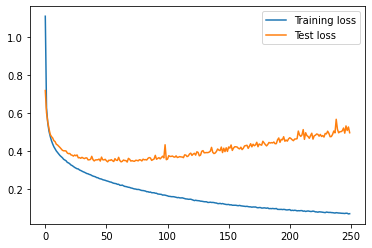

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(train_tracker, label='Training loss')
plt.plot(test_tracker, label='Test loss')
plt.legend()

- Now add the accuracy to the mix.

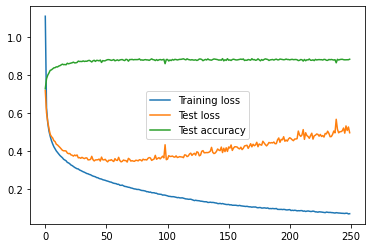

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(train_tracker, label='Training loss')
plt.plot(test_tracker, label='Test loss')
plt.plot(accuracy_tracker, label='Test accuracy')
plt.legend()

## Further challenges and experiments
- Can you get better accuracy from a model if you :
    - Add more layers?
    - Change the number of nodes in the layers?
    - Train over fewer/higher epochs?
    
- Can you improve on your results if you add additional layers like [Dropout](https://pytorch.org/docs/master/nn.html#torch.nn.Dropout)